## 1.3. processing and visualization of all subsets

This notebook filters all 4 subsets (control, 3h, 24h and 72h) in the complete time series. In notebook 1.1, clusters were assigned to the control subset. Here, we will transfer those clusters to the other four datasets by using a nearest neighbour label transfer. 

In order to run this notebook make sure the folder `../data/cellranger_output/` contains four folders (one for each timepoint) with the raw count matrix (`matrix.mtx`), the individual cell barcodes (`barcodes.tsv`) and the gene names (`features.tsv`). Unfortunately these files are to large to be added to the Github repository, so you can download those [here](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE226824). 

You will also need the file with the hashtag barcodes for each timepoint. These files can be found in the Github repository under `../data/hashtags/`.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0

# other 
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for transforming matrix from sparse to dense 
import os #to get absolute path of file
plt.rcParams['pdf.fonttype'] = 42 #for saving PDF with changeable text
plt.rcParams['ps.fonttype'] = 42 #for saving PDF with changeable text

# import own functions
from plotting import *
from utils import *

In [2]:
### load R into Notebook 
%load_ext rpy2.ipython 

### Load subsets
All 4 timepoints are loaded into seperate Anndata objects from the cellranger output files (matrix.mtx, barcodes.tsv and features.tsv).

In [3]:
### get cell ranger data directory
data_dir = '../data/cellranger_output/'

### get hashtag directory
hashtag_dir = '../data/hashtags/'

Here we are loading all 4 subsets into separate Anndata objects. This might take a few minutes.

In [4]:
### load subsets
timepoints = ["control", "3h", "24h", "72h"]

adata_list = {}

for timepoint in timepoints:
    # load subset
    data_path = data_dir + timepoint
    adata = sc.read_10x_mtx(path=data_path)
    
    # add adata to dictionary
    adata_list[timepoint] = adata

In [5]:
### add hashtags to all subsets
for timepoint in adata_list:
    hashtag_path = f"{hashtag_dir}hashtags_{timepoint}.csv"
    hashtags = pd.read_csv(hashtag_path, index_col=0)
    adata_list[timepoint].obs["hashtags"] = hashtags[["hash.ID"]]

### Filtering

In [6]:
for timepoint in adata_list:
    adata_list[timepoint] = filter_data(adata_list[timepoint], mito_perc=5, min_genes=700, no_doublet=True, no_negative=True)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [7]:
adata_list

{'control': AnnData object with n_obs × n_vars = 2474 × 27998
     obs: 'hashtags',
 '3h': AnnData object with n_obs × n_vars = 1661 × 27998
     obs: 'hashtags',
 '24h': AnnData object with n_obs × n_vars = 3462 × 27998
     obs: 'hashtags',
 '72h': AnnData object with n_obs × n_vars = 2449 × 27998
     obs: 'hashtags'}

### Find HVGs

Before integrating data we will identify the top 2000 most variable genes in each subset. The total number of HVGs is lower than (4x2000=) 8000, because most genes are found in more than one subset. We will preserve the found HVGs and remove all other genes. 

In [8]:
hvgs = [get_hvgs(adata_list[timepoint], no_of_hvgs=2000, theta=100)for timepoint in adata_list]
hvgs = np.unique(np.concatenate(hvgs, axis=0)) #remove double entries

In [9]:
### load cell cycle genes
cc_path = "../data/gene_lists/cell_cycle_marker_genes.csv"
cc_markers = pd.read_csv(cc_path, sep=";")
cc_markers = cc_markers["gene"].values
cc_markers = np.unique(cc_markers)

In [10]:
### remove cell cycle genes from hvgs
hvgs = np.setdiff1d(hvgs,cc_markers)

In [11]:
len(hvgs)

3326

### Data integration 

Here, we will integrate all four subsets into one. The integrated data will later be used to calculate the dimension reduction (PCA and UMAP) and to transfer the cluster labels from the control subset to the other three subsets. Data integration method used is Scanoroma (Hie, Bryson & Berger 2019 https://doi.org/10.1038/s41587-019-0113-3). Note: this data integration is only for the visualization of the data. In the downstream analyses we will use non-integrated data to see the effect of the treatment.

In [12]:
### combine 4 subsets
combined = adata_list[timepoints[0]].concatenate(adata_list[timepoints[1]], 
                                                 adata_list[timepoints[2]], 
                                                 adata_list[timepoints[3]], 
                                                 batch_key="time", 
                                                 batch_categories=timepoints)

In [13]:
### make subset with HVGs only
combined_hvgs = combined[:, hvgs].copy() 

In [14]:
### L2 normalize dataset
combined_hvgs.X = sk.preprocessing.normalize(combined_hvgs.X, norm='l2')

Here we add the batch corrected "scanoroma space" (stored in .obsm["X_scanorama"]) to the Anndata object. Additionally, a scanoroma space, reduced to a 100 dimensions is added (in .obsm["X_scanorama_reduced"]). The functions might take a few minutes to run. 

In [15]:
### get space in which the different timepoints are integrated
scanorama_df = integrate_datasets(combined_hvgs, combined_hvgs.X.todense(), batch_key="time", n_comps=100)

[[0.         0.02627324 0.75788197 0.22109943]
 [0.         0.         0.35460566 0.09151114]
 [0.         0.         0.         0.72233565]
 [0.         0.         0.         0.        ]]
Processing datasets control <=> 24h
Processing datasets 24h <=> 72h
Processing datasets 3h <=> 24h
Processing datasets control <=> 72h


In one of the downstream analyses (differential abundance analysis, R script 5.1) we will need the batch-corrected, Scanorama-reduced dimensions. Therefore, we will save those in a .csv file.

In [16]:
### save scanorama reduced dimensions in csv file
name_file = "scanorama_reduced_dimensions.csv"
save_path  = f"../results/processing/{name_file}"
scanorama_df.to_csv(save_path, header=True, index=True)

### UMAP representation of data
Here we will use the integrated data to calculate the UMAP representation of the 4 subsets combined. 

In [17]:
### calculate NN
sc.pp.neighbors(combined_hvgs, n_neighbors=20, use_rep = "X_scanorama_reduced") 

In [18]:
### calculate UMAP 
sc.tl.umap(combined_hvgs)

... storing 'hashtags' as categorical


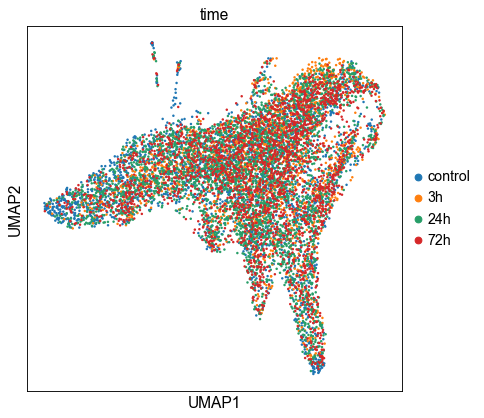

In [19]:
### plot all 4 timepoints in UMAP 
sc.set_figure_params(figsize = (6,6))
sc.pl.umap(combined_hvgs, color="time", size=20)

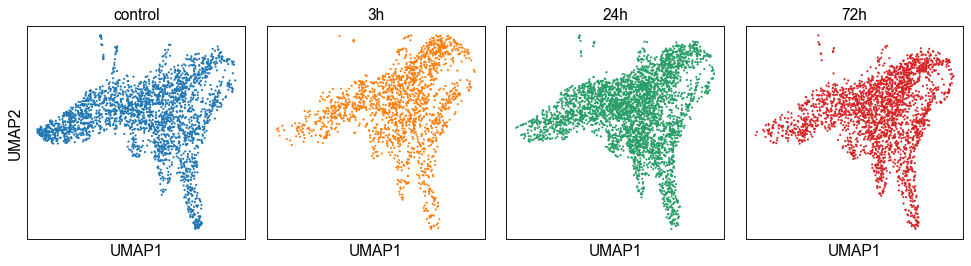

In [20]:
### plot each timepoint in individual umap
timepoints = combined_hvgs.obs["time"].cat.categories

fig, axs = plt.subplots(1, len(timepoints), figsize=(15,3.5), gridspec_kw={'wspace':0.1, 'hspace':0.1})

for i in range(len(timepoints)):
    sc.pl.umap(combined_hvgs[combined_hvgs.obs["time"]==timepoints[i]], color="time", ax=axs[i], show=False, size=15, title=timepoints[i])

for ax in axs.flat:
    ax.get_yaxis().set_visible(False)
    ax.get_legend().remove()

axs[0].get_yaxis().set_visible(True)

# save figure
#save_path = "../figures/1.3.UMAP_per_timepoint_HSPC-all_time_coloured.png"
#fig.savefig(save_path, bbox_inches='tight', format='png', dpi=300)

### Load cell type labels control in combined dataset

In notebook 1.1 we assigned cell type labels to the control subset. Here, we will load these label into the combined Anndata object that we generated in this code. If you want to see how the clusters were calculated in the control subset run notebook 1.1. However, the clusters and there assigned cell types are also loaded as .csv files on the GitHub, so if you don't want to run notebook 1.1, you can also use those files (make sure they are in the right directory or change their paths below if you store them elsewhere).

In [21]:
### Load clusters labels from control subset
clusters_path  = "../results/processing/control_clusters.csv"
clusters = pd.read_csv(clusters_path, index_col=0)
clusters.index = clusters.index + "-control" #add control to cell name
clusters = pd.Series(clusters["clusters"], dtype="category") #convert to series

In [22]:
### add control clusters to dataset
combined_hvgs.obs["clusters"] = clusters

In [23]:
### change order of clusters
new_order = ['HSCs #1','HSCs #2',
             'LMPPs #1','LMPPs #2',
             'myel. prog. #1','myel. prog. #2','myel. prog. #3',
             'ery. prog. #1','ery. prog. #2','ery. prog. #3',
             'MK prog.','monocytes',
             'eosinophil prog.','eosinophils']
combined_hvgs.obs["clusters"] = combined_hvgs.obs["clusters"].cat.reorder_categories(new_order)

In [24]:
### put colors in right order in clusters
combined_hvgs.uns["clusters_colors"] = [
    '#8c564b','#d62728',
    '#F08D2A','#FEC800',
    '#9ED93F','#4E9639','#203E34',
    '#aec7e8','#17becf','#1f77b4',
    '#CCBFA8','#e377c2',
    '#ff9896','#c5b0d5']

Before transferring the cluster labels we plot the control clusters on the UMAP with the complete dataset. Since the cells in timepoints 3h, 24h and 72h are not yet assigned a cluster label, they will be plotted in grey.

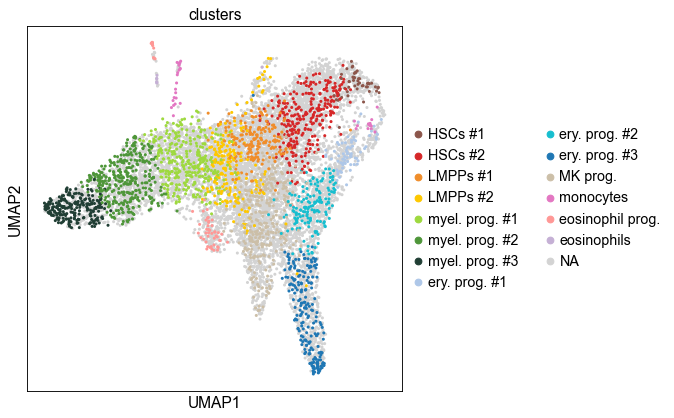

In [25]:
### plot control clusters in UMAP
sc.set_figure_params(figsize = (6,6))
sc.pl.umap(combined_hvgs, color = 'clusters', size=30)

### Cluster label transfer
Here we transfer the labels from the control subset (as assigned in notebook 1.1) to the other 3 timepoints. We use the reduced Scanorama space to find the nearest neighbours of each cell in the control subset. Then, we assign the label that is most common among the nearest neighbours to the selected cell.

In [26]:
### get cluster labels and add to .obs 'clusters'
for timepoint in ["3h", "24h", "72h"]:
    labels = label_transfer(combined_hvgs, reference="control", query=timepoint, no_neighbours=10)
    combined_hvgs.obs['clusters'][labels.index] = labels.astype(str)

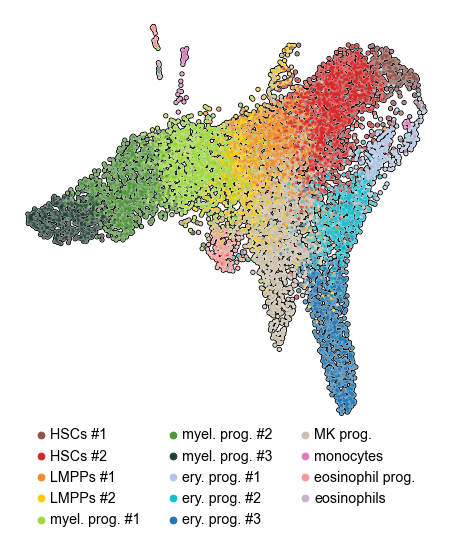

In [27]:
### plot HSPC dataset with all clusters in UMAP
fig, ax = plt.subplots(1,1,figsize=(7,7))
sc.pl.umap(combined_hvgs, color = 'clusters', size=30, 
           ax=ax, show=False, title="", add_outline=True)
#ax.legend(loc='center right', bbox_to_anchor=(1.32, 0.5), ncol=1, frameon=False)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=3, frameon=False)
plt.axis('off')
plt.show()

# save figure
save_path = "../figures/1.3.UMAP_HSPC-all_clusters.pdf"
fig.savefig(save_path, bbox_inches='tight', format='pdf', dpi=600)

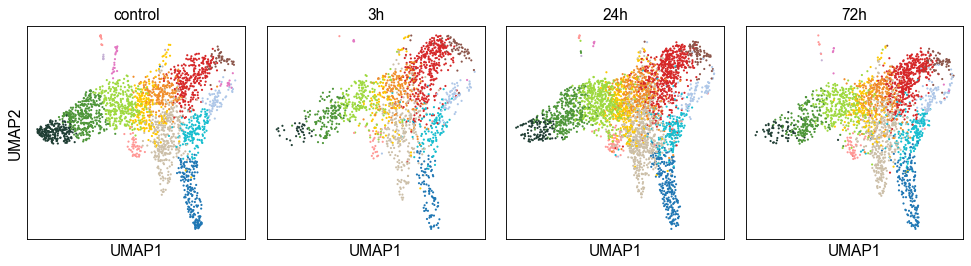

In [28]:
### plot clusters in each timepoint (four UMAPs)
timepoints = combined_hvgs.obs["time"].cat.categories

fig, axs = plt.subplots(1, len(timepoints), figsize=(15,3.5), gridspec_kw={'wspace':0.1, 'hspace':0.1})

for i in range(len(timepoints)):
    sc.pl.umap(combined_hvgs[combined_hvgs.obs["time"]==timepoints[i]], color="clusters", ax=axs[i], show=False, size=15, title=timepoints[i])

for ax in axs.flat:
    ax.get_yaxis().set_visible(False)
    ax.get_legend().remove()

axs[0].get_yaxis().set_visible(True)

### Save processed HSPC dataset
Lastly, we will save the Anndata object with clusters and UMAP reduction, all genes and the selected cells for downstream analyses.

In [29]:
### add clusters and umap to adata too
combined.obs["clusters"] = combined_hvgs.obs["clusters"].values
combined.uns["clusters_colors"] = combined_hvgs.uns["clusters_colors"]
combined.obsm["X_umap"] = combined_hvgs.obsm["X_umap"]
combined

AnnData object with n_obs × n_vars = 10046 × 27998
    obs: 'hashtags', 'time', 'clusters'
    uns: 'clusters_colors'
    obsm: 'X_umap'

For the downstream analyses we will remove the clusters assigned to the eosinophil or monocyte cell type, because of the extremely low numbers of cells in those clusters (10 and 52 respectively). 

In [30]:
### save Anndata object with all cell types
name_file = "all_filtered_all-clusters.h5ad"
adata_path  = "../data/count_matrices/" + name_file
combined.write_h5ad(adata_path)

... storing 'hashtags' as categorical


In [31]:
### remove 2 clusters with too few cells
combined = combined[(combined.obs["clusters"]!="monocytes")&
                    (combined.obs["clusters"]!="eosinophils")]
combined.obs["clusters"] = combined.obs["clusters"].cat.remove_unused_categories()

Trying to set attribute `.obs` of view, copying.


In [32]:
### save Anndata object
name_file = "all_filtered.h5ad"
adata_path  = "../data/count_matrices/" + name_file
combined.write_h5ad(adata_path)

### Convert Anndata object to Seurat object
Lastly, we will convert the Anndata object that we saved in `data/count_matrices` in a .h5ad format to a .h5seurat format. This allows us to use the filtered matrix (with clusters and UMAP assigned) in different R scripts. 

In [33]:
### get absolute path of anndata object
adata_path = os.path.abspath(adata_path)

In [34]:
%%R -i adata_path 

### load packages
library(Seurat) 
library(SeuratDisk)

### load dataset
dataset_dir <- adata_path

### convert h5ad to h5seurat 
Convert(dataset_dir, paste0(tools::file_path_sans_ext(dataset_dir), ".h5seurat"), overwrite=TRUE)

R[write to console]: Attaching SeuratObject

R[write to console]: Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

R[write to console]: Warnung:
R[write to console]:  Unknown file type: h5ad

R[write to console]: Warnung:
R[write to console]:  'assay' not set, setting to 'RNA'

R[write to console]: Creating h5Seurat file for version 3.1.5.9900

R[write to console]: Adding X as data

R[write to console]: Adding X as counts

R[write to console]: Adding meta.features from var

R[write to console]: Adding X_umap as cell embeddings for umap

R[write to console]: Adding clusters_colors to miscellaneous data

